# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 



1.   Will tranmission significantly make a car more expensive? 
2.   How does the factors of the car (e.g., model, transmission type, condition, odometer, ...) affect whether the car will be more expensive?
3.   What condition do the consumers value the most in a used car?
4.   Predict the price of a used car by the given factors.





### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1) First, I will find out how many columns are in the dataset and their types and correlations.

In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

#import csv data

df = pd.read_csv("data/vehicles.csv")
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type   

2) I will then find out whether the dataset contains NaN or duplicated data.

In [6]:
#find out number of rows containing NaN data
df.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [7]:
#find out number of duplicated records
df.duplicated().sum()

0

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Step 1) Remove NaN rows

In [8]:
#drop rows with NaN since we won't use them in analysis
df = df.dropna()

Step 2) Remove useless columns

In [9]:
#drop unnecessary columns since they are just identifiers, no use in my analysis 
df = df.drop('id', axis = 1)
df = df.drop('VIN', axis = 1)

In [10]:
#check the data
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
126,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,full-size,van,white,al
127,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,full-size,van,white,al
128,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,full-size,van,white,al
215,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al


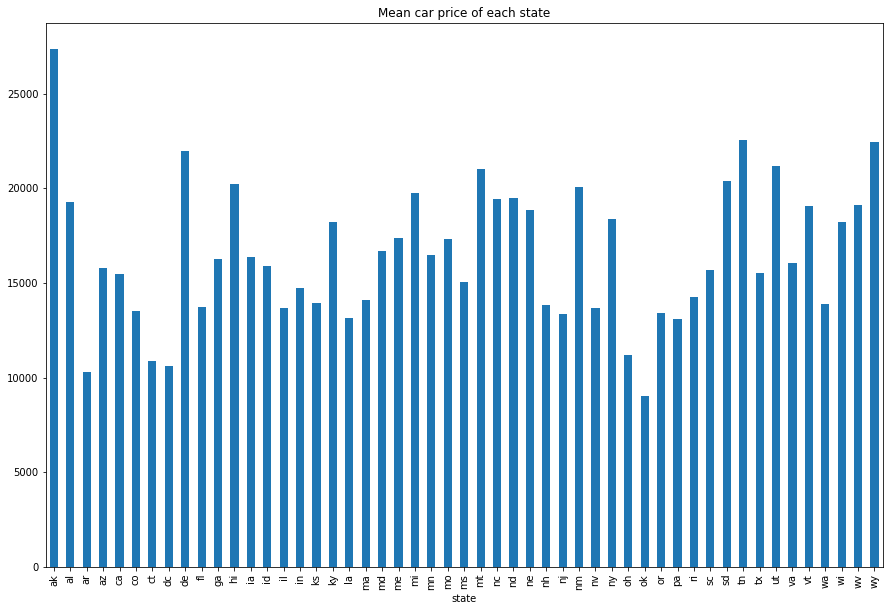

In [11]:
#check the mean car price of each state to see if there is any signicant findings
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Mean car price of each state')
df.groupby(['state']).mean()['price'].plot.bar(ax=ax)

In [12]:
#From the grapgh above, I found that locations do not have significant correlation to the prices. Therefore, I will remove 'state'
df = df.drop(columns = ['state'])

In [13]:
#Since I am going to see which feature will lead to higher car price, I will remove geographic related columns
df = df.drop(columns = ['region'])

Step 3) Remove useless record entries

In [14]:
#I found that the price of some cars are of zero price. I remove those rows.
df = df[df['price']>0]

In [15]:
#Cars that are too old will have a higher uncertainty to the data prediction because of low availability (lack of repairement components' replacement).
#Some of the cars maybe antiques and vintage, so I will use the datasets with year after 1970.
df = df[df['year']>1970]

Step 4) Check and remove outliers

First, I removed **price** outliers.

In [16]:
#check the minimum price after removing those zero priced rows
df['price'].min()

1

In [17]:
#remove those price outliers in the dataset
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
filter = (df['price'] >= Q1 - IQR*1.5) & (df['price'] <= Q3 + IQR*1.5)
initSize = df.count()['price']
df = df.loc[filter]  
filteredSize = df.count()['price']
print(initSize-filteredSize,'(', '{:.2f}'.format(100*(initSize-filteredSize)/initSize), '%',')', 'outliers removed')


1122 ( 3.47 % ) outliers removed


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

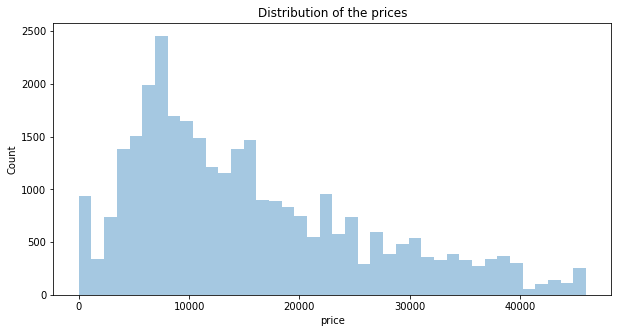

In [18]:
#visualize and check the distributino of prices
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Distribution of the prices')
sns.distplot(df['price'], bins=40, kde=False)
plt.ylabel("Count")

Second, I removed **Odometer** outliers.

In [19]:
#check the odometer min and max values
print('Odometer min:',df['odometer'].min())
print('Odometer max:',df['odometer'].max())

Odometer min: 0.0
Odometer max: 9999999.0


In [20]:
#remove those odometer outliers in the dataset
Q1 = df['odometer'].quantile(0.25)
Q3 = df['odometer'].quantile(0.75)
IQR = Q3 - Q1
filter = (df['odometer'] >= Q1 - IQR*1.5) & (df['odometer'] <= Q3 + IQR*1.5)
initSize = df.count()['odometer']
df = df.loc[filter]
filteredSize = df.count()['odometer']
print(initSize-filteredSize,'(', '{:.2f}'.format(100*(initSize-filteredSize)/initSize), '%',')', 'outliers removed')

335 ( 1.07 % ) outliers removed


In [21]:
#check the odometer min and max values again
#we won't remove those odometer with 0 values because they may be new cars. It is reasonable to keep them for analysis
print('Odometer min:',df['odometer'].min())
print('Odometer max:',df['odometer'].max())

Odometer min: 0.0
Odometer max: 255039.0


Third, I removed **Manufacturer** outliers.

In [22]:
#Check manufacturer and their counts
df['manufacturer'].value_counts()

ford               6365
chevrolet          4577
toyota             2609
honda              1797
nissan             1590
ram                1276
jeep               1253
gmc                1179
dodge               879
subaru              872
bmw                 841
mercedes-benz       767
hyundai             720
volkswagen          710
kia                 572
lexus               567
chrysler            506
cadillac            460
audi                402
mazda               378
buick               355
mitsubishi          322
acura               236
volvo               229
infiniti            226
lincoln             225
pontiac             186
mini                165
rover               141
porsche             107
saturn               97
jaguar               81
mercury              78
fiat                 47
alfa-romeo           14
tesla                12
harley-davidson       7
datsun                2
land rover            2
aston-martin          1
ferrari               1
Name: manufactur

In [23]:
#Remove those rows with manufacturer count less than or equal to 10 (eg. remove outliers). I will just focus on the majority.
df = df.groupby('manufacturer').filter(lambda x: len(x) > 10)
df['manufacturer'].value_counts()

ford             6365
chevrolet        4577
toyota           2609
honda            1797
nissan           1590
ram              1276
jeep             1253
gmc              1179
dodge             879
subaru            872
bmw               841
mercedes-benz     767
hyundai           720
volkswagen        710
kia               572
lexus             567
chrysler          506
cadillac          460
audi              402
mazda             378
buick             355
mitsubishi        322
acura             236
volvo             229
infiniti          226
lincoln           225
pontiac           186
mini              165
rover             141
porsche           107
saturn             97
jaguar             81
mercury            78
fiat               47
alfa-romeo         14
tesla              12
Name: manufacturer, dtype: int64

Fourth, I removed **Model** outliers.

In [24]:
# I remove those models with just 1 sample since they are rare in the dataset, which may affect the prediction model.
# This will narrow the capability of the prediction model. However, I can get lower bias and variance.
init_size = df.count()['model']
df = df.groupby('model').filter(lambda x: len(x) > 1)
filtered_size = df.count()['model']
print(init_size-filtered_size,'(', '{:.2f}'.format(100*(init_size-filtered_size)/init_size), '%',')', 'outliers removed from dataset')
df['model'].value_counts()

2357 ( 7.64 % ) outliers removed from dataset


f-150                   792
silverado 1500          760
1500                    406
escape                  235
silverado 2500hd        231
                       ... 
2500 megacab laramie      2
patriot limited           2
rogue sl                  2
rdx sh-awd w/tech         2
f350, xlt                 2
Name: model, Length: 2311, dtype: int64

Step 5) Normalize the dataset

In [25]:
#normalize odometer
from sklearn.preprocessing import MinMaxScaler, minmax_scale
df_odometer_normalized = df.copy()
df_odometer_normalized["odometer"] = np.sqrt(minmax_scale(df_odometer_normalized["odometer"]))
df_odometer_normalized

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color
215,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,0.779583,clean,automatic,fwd,compact,sedan,blue
219,2500,1995.0,bmw,525i,fair,6 cylinders,gas,0.658710,clean,automatic,rwd,mid-size,sedan,white
268,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,0.471507,clean,automatic,rwd,compact,convertible,white
337,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,0.801897,clean,automatic,fwd,full-size,truck,white
338,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,0.587739,clean,automatic,rwd,full-size,coupe,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,ford,f150 xlt 4x4,like new,8 cylinders,gas,0.758669,clean,automatic,4wd,full-size,truck,black
426788,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,0.489568,clean,automatic,fwd,compact,sedan,silver
426792,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,0.778683,clean,automatic,4wd,full-size,pickup,brown
426793,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,0.378124,clean,automatic,fwd,mid-size,sedan,black


In [26]:
# Encode categorial columns
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline

df_odometer_normalized_with_oneHot = df_odometer_normalized.copy()

# Encode condition column
df_carCondition_conditions = [
    (df_odometer_normalized_with_oneHot['condition'] == 'salvage'),
    (df_odometer_normalized_with_oneHot['condition'] == 'fair'),
    (df_odometer_normalized_with_oneHot['condition'] == 'good'),
    (df_odometer_normalized_with_oneHot['condition'] == 'excellent'),
    (df_odometer_normalized_with_oneHot['condition'] == 'like new'),
    (df_odometer_normalized_with_oneHot['condition'] == 'new')
    ]

df_carCondition_values = [1, 2, 3, 4, 5, 6]
df_odometer_normalized_with_oneHot['condition'] = np.select(df_carCondition_conditions, df_carCondition_values)
df_odometer_normalized_with_oneHot_condition = df_odometer_normalized_with_oneHot['condition']

#make use of make_column_transformer, one hot encoder to encode the columns
categorical_columns = ["manufacturer", "cylinders", "fuel", "title_status", "transmission", "drive", "size", "type", "paint_color"]
#I removed "model" from the above list to be processed by One Hot Encoder since it has 2318 unique values. There will be many columns
numerical_columns = ["price", "year"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)
pipeline = make_pipeline(preprocessor, LinearRegression())

X = df_odometer_normalized_with_oneHot[categorical_columns]
y = df_odometer_normalized_with_oneHot['price']

pipeline.fit(X, y)

#build the dataframe with encoded columns and remove the original categorical columns
df_odometer_normalized_with_oneHot = pd.get_dummies(X)
df_odometer_normalized_with_oneHot = pd.concat([df_odometer_normalized.copy(),df_odometer_normalized_with_oneHot],axis=1)

del df_odometer_normalized_with_oneHot['condition']
df_odometer_normalized_with_oneHot = pd.concat([df_odometer_normalized_with_oneHot,df_odometer_normalized_with_oneHot_condition],axis=1)

for cat in categorical_columns:
  del df_odometer_normalized_with_oneHot[cat]

df_odometer_normalized_with_oneHot

,price,year,model,odometer,manufacturer_acura,manufacturer_alfa-romeo,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,condition
215,4000,2002.0,echo,0.779583,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
219,2500,1995.0,525i,0.658710,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,2
268,9000,2008.0,miata mx-5,0.471507,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
337,8950,2011.0,f-150,0.801897,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
338,4000,1972.0,benz,0.587739,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015.0,f150 xlt 4x4,0.758669,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
426788,12995,2016.0,cruze lt,0.489568,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5
426792,32999,2014.0,"f350, xlt",0.778683,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
426793,15999,2018.0,"cruze, lt",0.378124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


Step 6) Data checking

In [27]:
#check the columns correlation with price
df_odometer_normalized_with_oneHot.corr()['price'].sort_values()

drive_fwd               -0.401024
odometer                -0.378463
type_sedan              -0.337799
fuel_gas                -0.306353
cylinders_4 cylinders   -0.289571
                           ...   
cylinders_8 cylinders    0.334617
fuel_diesel              0.354450
type_truck               0.424126
year                     0.424538
price                    1.000000
Name: price, Length: 94, dtype: float64

From the above, "8 cylinders", "fuel_diesel", "type_truck", "year" have relatively high correlation with the price

In [28]:
#check the present dataframe description
df_odometer_normalized_with_oneHot.describe().T

,count,mean,std,min,25%,50%,75%,max
price,28484.0,15695.277524,10617.499429,1.0,7499.00000,12995.000000,21995.500000,46000.0
year,28484.0,2011.339629,5.618800,1971.0,2008.00000,2012.000000,2015.000000,2021.0
odometer,28484.0,0.625706,0.176924,0.0,0.52538,0.647722,0.747787,1.0
manufacturer_acura,28484.0,0.007443,0.085951,0.0,0.00000,0.000000,0.000000,1.0
manufacturer_alfa-romeo,28484.0,0.000386,0.019648,0.0,0.00000,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...
paint_color_red,28484.0,0.086329,0.280854,0.0,0.00000,0.000000,0.000000,1.0
paint_color_silver,28484.0,0.142501,0.349569,0.0,0.00000,0.000000,0.000000,1.0
paint_color_white,28484.0,0.278332,0.448185,0.0,0.00000,0.000000,1.000000,1.0
paint_color_yellow,28484.0,0.005968,0.077025,0.0,0.00000,0.000000,0.000000,1.0


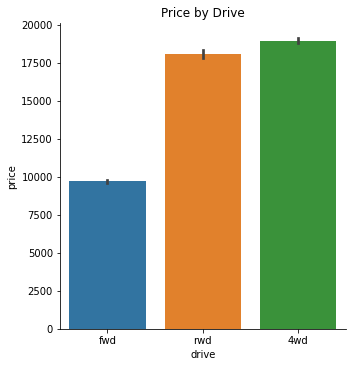

In [83]:
sns.catplot(x="drive", y="price",kind="bar", data=df_odometer_normalized).set(title='Price by Drive')

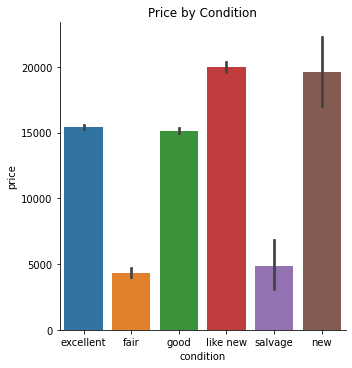

In [84]:
sns.catplot(x="condition", y="price",kind="bar", data=df_odometer_normalized).set(title='Price by Condition')

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
import scipy as sp

X = pd.concat([df_odometer_normalized[categorical_columns+['year']],df_odometer_normalized_with_oneHot['condition']],axis=1)
y = df_odometer_normalized['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

#First, I built a regression model by first preprocess the categorial features by one-hot encoder. 
#Second, I tranform the target using by using regressor=Ridge(alpha=1e-9) and logarithm.
#The coefficients of the regressor I have fitted became:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-9), func=np.log10, inverse_func=sp.special.exp10
    ),
)
model.fit(X_train, y_train)

feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.shape

(92, 1)

In [32]:
coefs.sort_values('Coefficients')

,Coefficients
transmission_other,-1.574455
cylinders_10 cylinders,-1.071218
type_wagon,-0.556075
manufacturer_bmw,-0.220223
manufacturer_mitsubishi,-0.205925
...,...
manufacturer_porsche,0.387663
manufacturer_tesla,0.459177
cylinders_3 cylinders,0.607246
transmission_automatic,0.776031


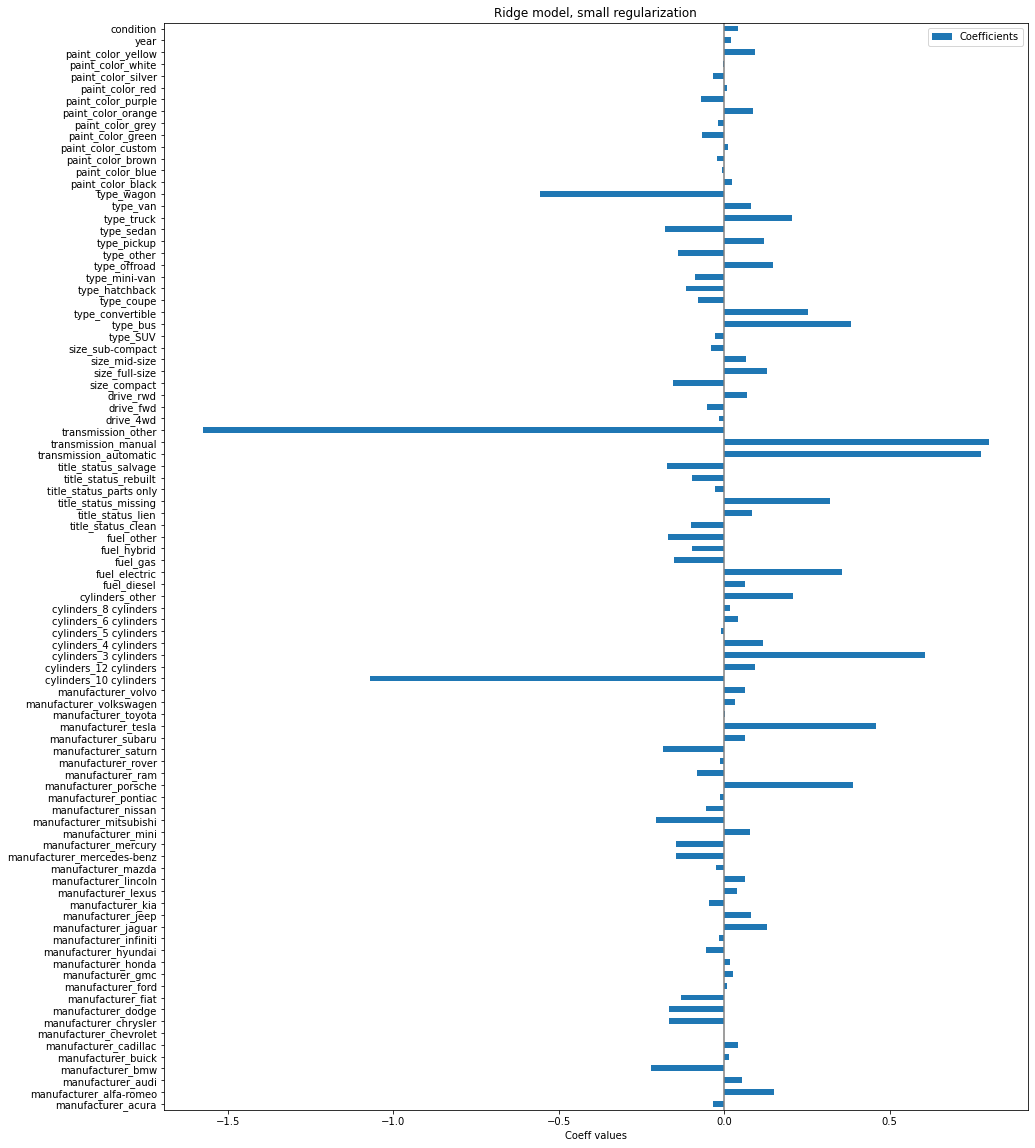

In [33]:
coefs.plot.barh(figsize=(20, 20))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Coeff values")
plt.subplots_adjust(left=0.3)

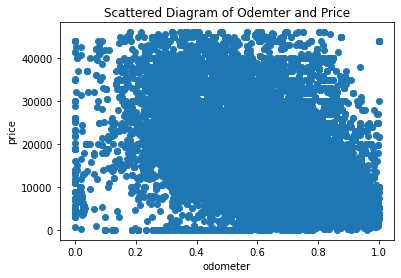

In [34]:
x = df_odometer_normalized_with_oneHot['odometer']
plt.scatter(x, y)
plt.xlabel('odometer')
plt.ylabel('price')
plt.title('Scattered Diagram of Odemter and Price')
plt.show()

From the graph above, there are less data between 0.1 and 0.2 scaled odometer.

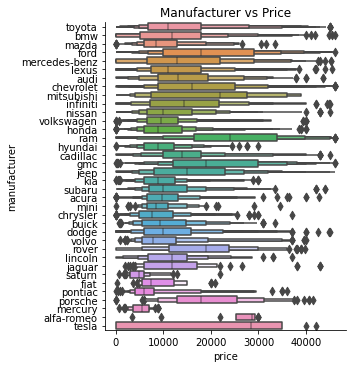

In [86]:
catP = sns.catplot(y="manufacturer", x="price",kind="boxen", data=df_odometer_normalized).set(title='Manufacturer vs Price')

From the above graph, it seems that manufacturer "ram" has a higher price.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


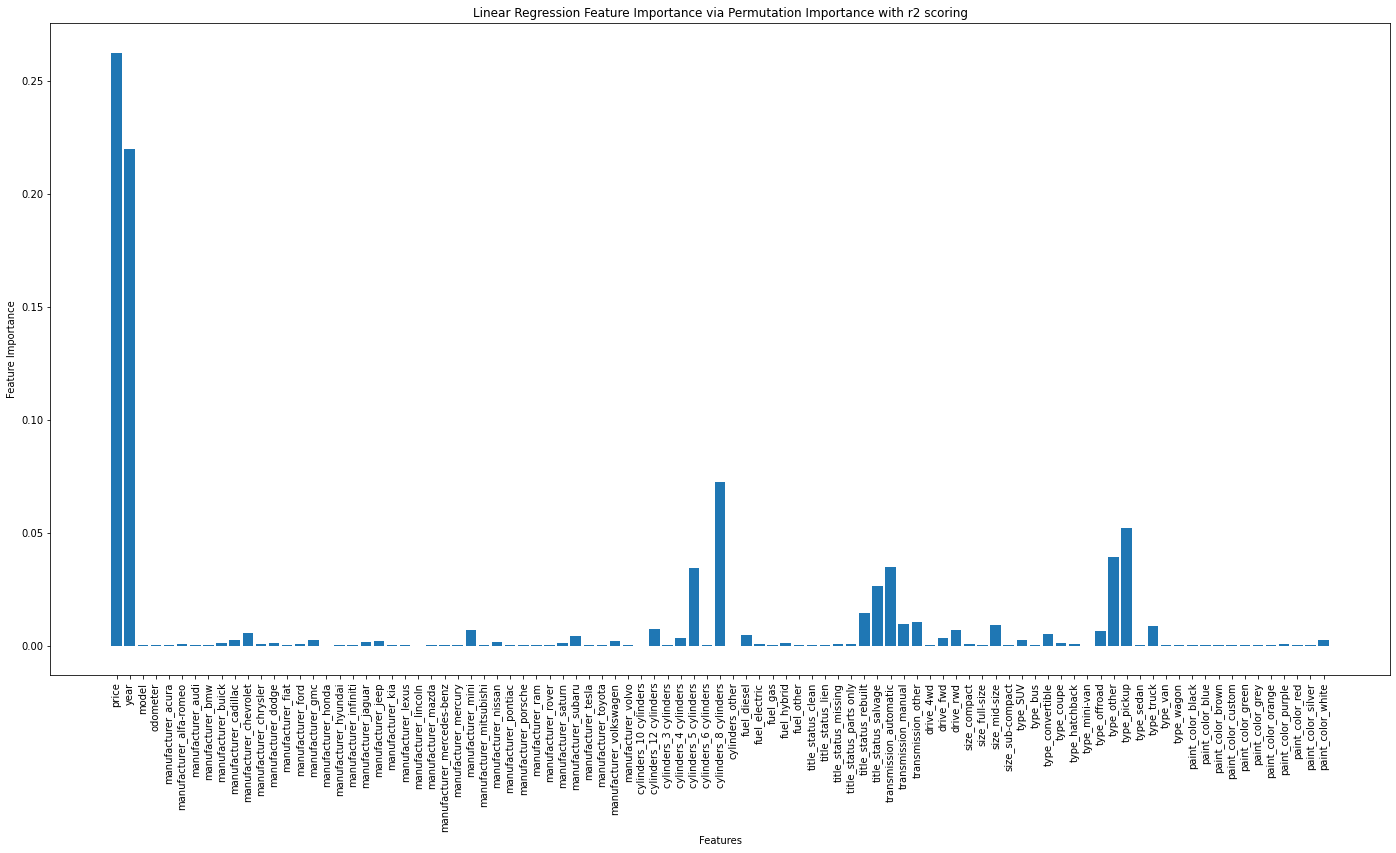

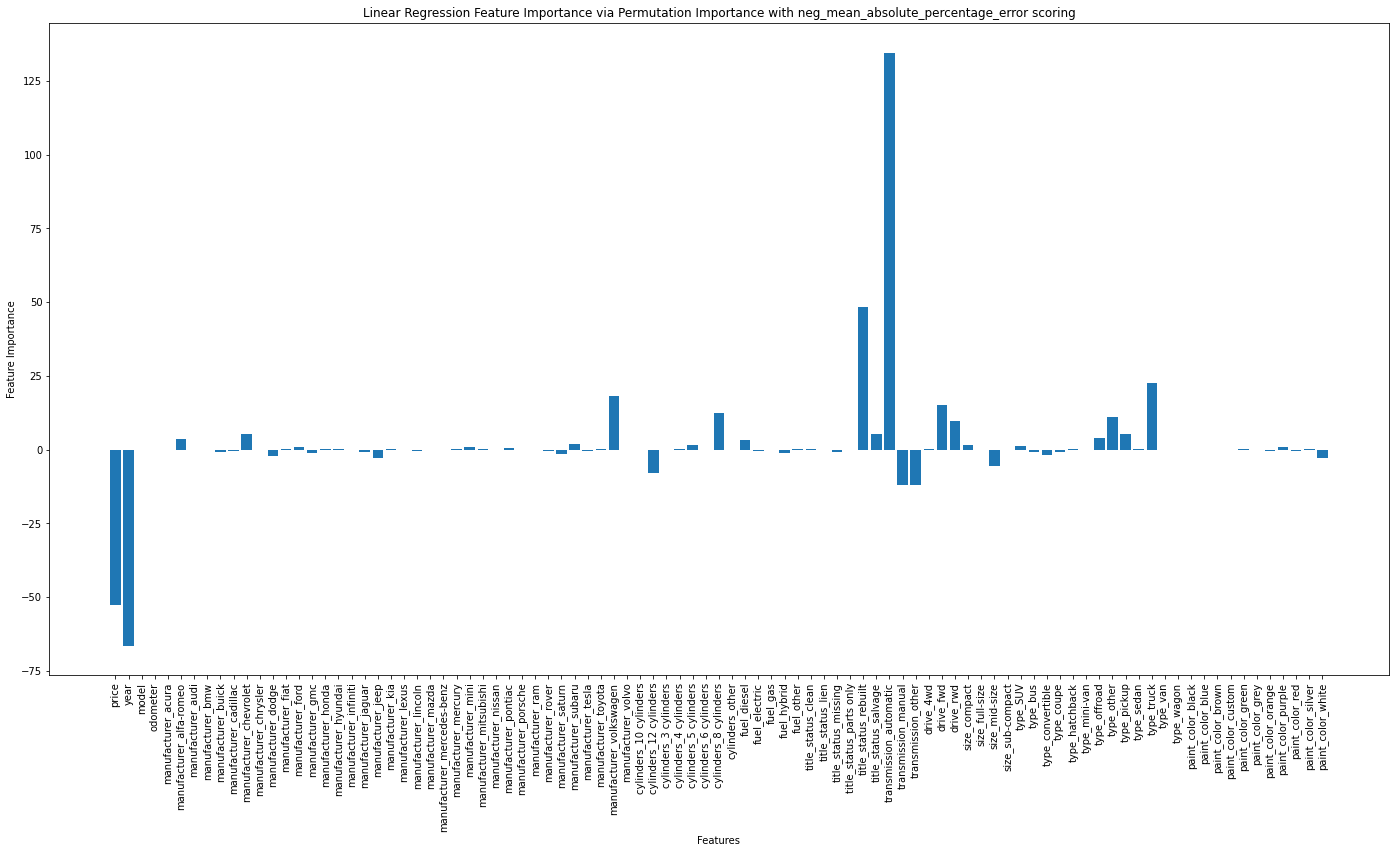

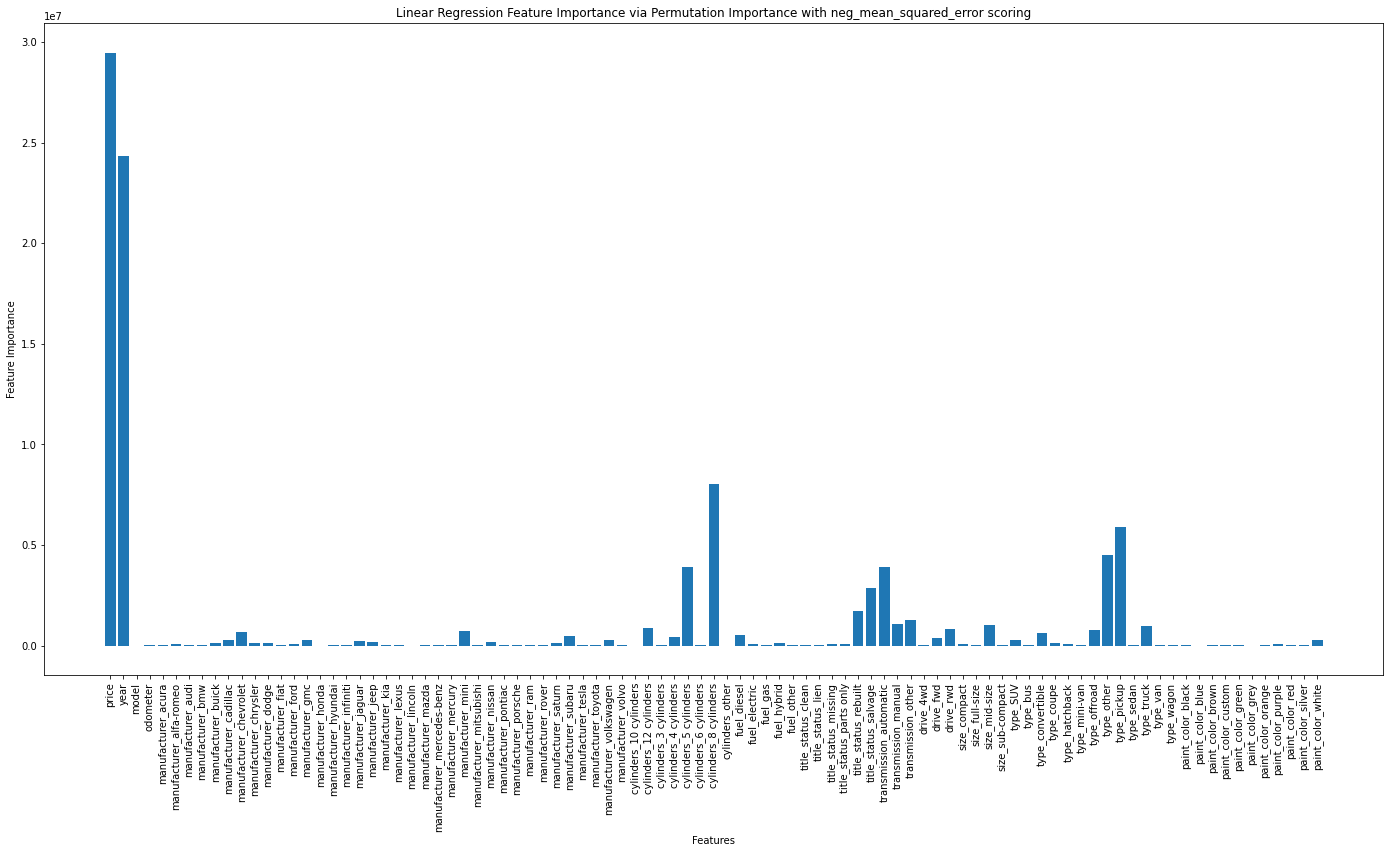

In [38]:
# Find important features by linear regression and permutation importance
from sklearn.inspection import permutation_importance
model = LinearRegression()

X = df_odometer_normalized_with_oneHot.drop('model',1).drop('price',1)
y = df_odometer_normalized_with_oneHot['price']

# fit the model
model.fit(X, y)

# perform permutation importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
results = permutation_importance(model, X, y, scoring=scoring)

#if we want to know the exact mean and std, we can remove the hash tags below:

#for metric in results:
#  print(f"{metric}")
#  print("mean +/- std")
#  r = results[metric]
#  for i in r.importances_mean.argsort()[::-1]:
#    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#      print(f"{r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")
# plot feature importance


for i in range(0,3):
  results = permutation_importance(model, X, y, scoring=scoring[i])
  importance = results.importances_mean
  plt.figure(figsize=(24, 12))
  plt.bar([df_odometer_normalized_with_oneHot.columns[x] for x in range(len(importance))], importance)
  plt.xlabel('Features') 
  plt.ylabel('Feature Importance')
  plt.xticks(rotation=90)
  plt.title("Linear Regression Feature Importance via Permutation Importance with "+scoring[i]+" scoring")
  plt.show()

From the graphs above, "year" is the most important feature, followed by 8 cylinders and automatic transmission.

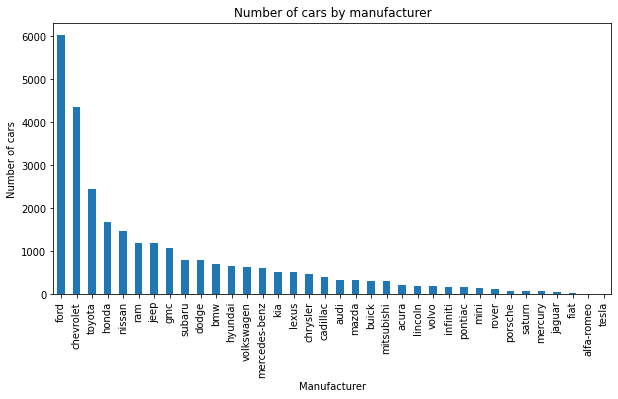

In [40]:
# Plotting a Histogram for cars made by the manufacturer
df_odometer_normalized.manufacturer.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Number of cars by manufacturer")
plt.ylabel('Number of cars')
plt.xlabel('Manufacturer');

I am going to use cross validation to find the best model.

In [46]:
#Find the MSE by StratifiedKFold and LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import numpy as np


X = df_odometer_normalized_with_oneHot.drop('model',1).drop('price',1)
y = df_odometer_normalized_with_oneHot['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

logs=[]
skf=StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
bins=np.histogram_bin_edges(y,bins='sturges')
y_binned=np.digitize(y, bins)
for train_index, test_index in skf.split(X,y_binned):
    lr=LinearRegression()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train, y_train)
    y_pred=lr.predict(X_test)
    logs.append(mean_squared_error(y_test, y_pred))
print(logs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  UserWarning,


[34604558.990391366, 6.074494041981709e+24, 34021709.27877103, 36334955.59769267, 33081696.07181752, 38448197.64160002, 34310401.68474881, 36593496.10998582, 35196211.089984156, 35606261.48681646]


Size of Dataset 28484
[-1039.23921684 -1330.22697919 15903.85379519 ... 30681.69593706
 17807.27348897 12101.29794008]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


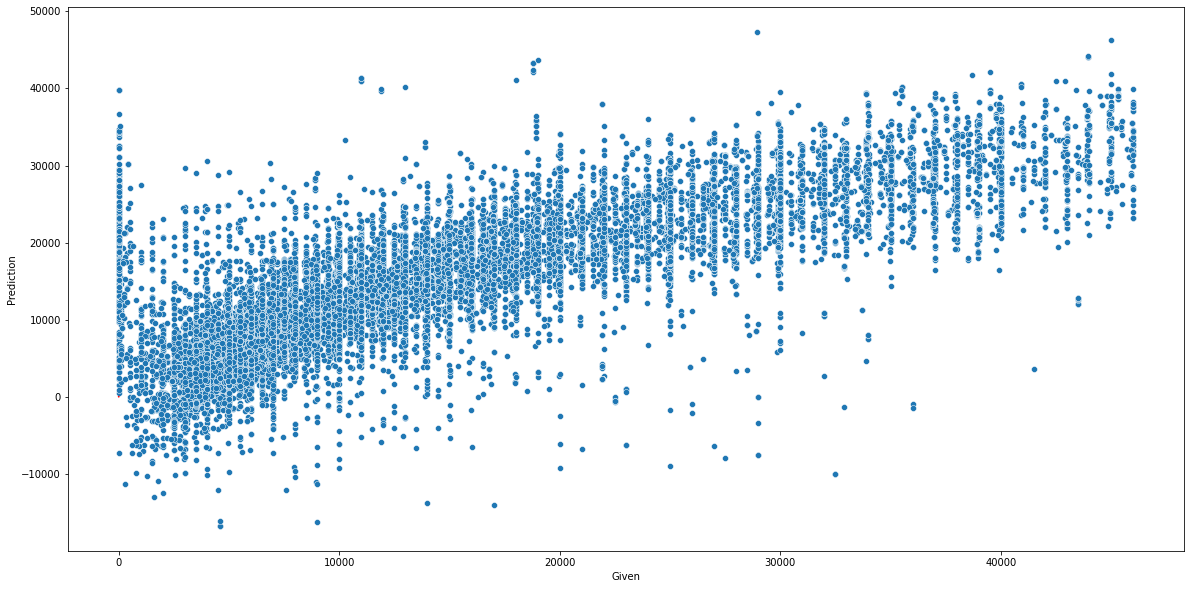

In [51]:
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import seaborn as sns


X2=X.copy()
Y2=df_odometer_normalized_with_oneHot['price']
print("Size of Dataset {}".format(len(X2)))
logreg=LinearRegression()
x_train,x_test,y_train,y_test=train_test_split(X2,Y2,test_size=0.3,random_state=42)

# use cross_val_predict to generate K-Fold predictions
lm_k = LinearRegression()
k_predictions = cross_val_predict(lm_k, X2, Y2, cv=10)
print(k_predictions)

plot_k = sns.scatterplot(Y2, k_predictions)
plot_k.set(xlabel='Given', ylabel='Prediction')
# generate and graph y = x line
x_plot = np.linspace(0,5,100)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')

-40193995.990438685


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'neg_mean_squared_error'),
 Text(0.5, 1.0, 'neg_mean_squared_error density')]

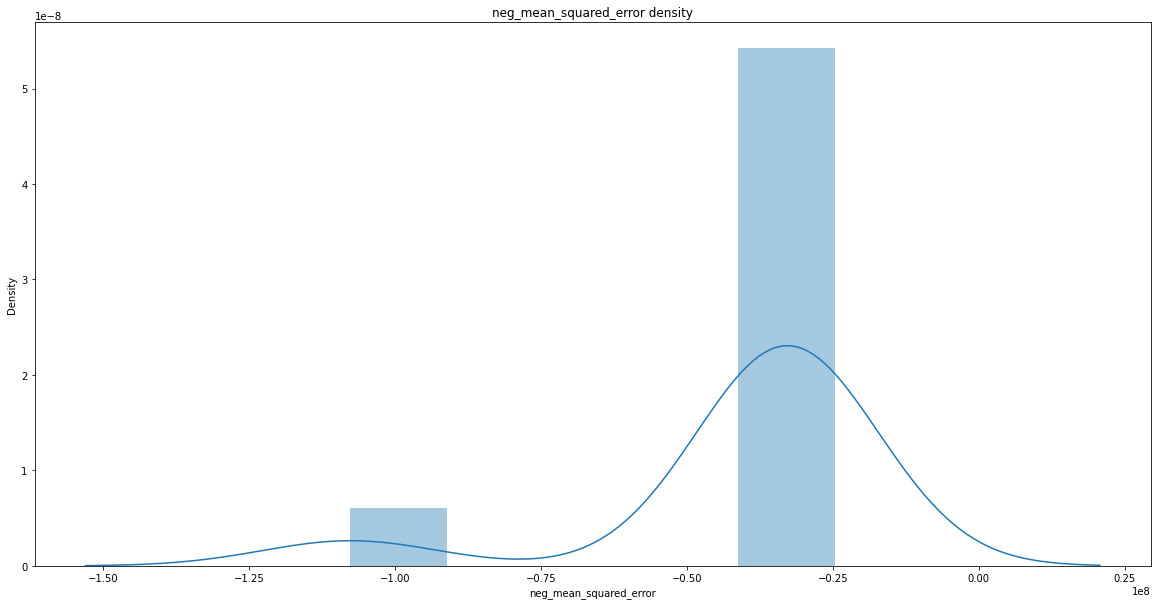

In [81]:
#Find the kfold scores
kfold_scores = cross_val_score(lm_k, X2, Y2, cv=10, scoring='neg_mean_squared_error')
print(kfold_scores.mean())
sns.distplot(kfold_scores, bins=5).set(xlabel='neg_mean_squared_error', title='neg_mean_squared_error density')

Since the values of the above resutls are relatively huge, I try other modelling with cross-validation.

ScaledLR: -8.281193941286663e+24 (1.6562387882573326e+25)
ScaledRIDGE: -35611640.33019067 (1919839.3521144316)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.875e+08, tolerance: 1.739e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


ScaledLASSO: -35633568.0374332 (1919294.3421652853)
ScaledEN: -79995012.2687619 (1090829.8223704793)
ScaledSVR: -115570822.3972791 (944977.2467189251)
ScaledKNN: -29889429.41949038 (1229911.6564551261)
ScaledCART: -19808604.882092196 (1016253.0415142706)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

ScaledNN: -36538987.69266442 (1513465.732957924)


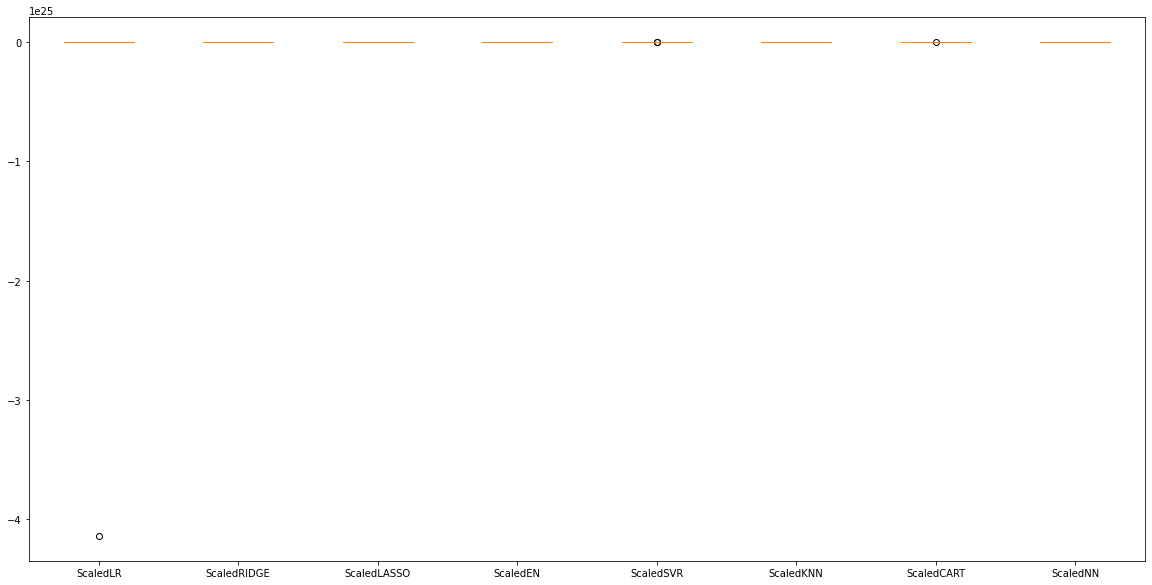

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_val_score

import seaborn as sns

plt.rcParams["figure.figsize"] = (20,10)

# Split dataset
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

# Check algorithms
## Testing options
number_folds = 5
seed = 42
scoring = 'neg_mean_squared_error'

## Define testing workflow and select model
models = []
models.append(("ScaledLR", Pipeline([('Scaler', MinMaxScaler()), ('LR', LinearRegression())])))
models.append(("ScaledRIDGE", Pipeline([('Scaler', MinMaxScaler()), ('RIDGE', Ridge())])))
models.append(("ScaledLASSO", Pipeline([('Scaler', MinMaxScaler()), ('LASSO', Lasso())])))
models.append(("ScaledEN", Pipeline([('Scaler', MinMaxScaler()), ('EN', ElasticNet())])))
models.append(("ScaledSVR", Pipeline([('Scaler', MinMaxScaler()), ('SVR', SVR())])))
models.append(("ScaledKNN", Pipeline([('Scaler', MinMaxScaler()), ('KNN', KNeighborsRegressor())])))
models.append(("ScaledCART", Pipeline([('Scaler', MinMaxScaler()), ('CART', DecisionTreeRegressor())])))
models.append(("ScaledNN", Pipeline([('Scaler', MinMaxScaler()), ('NN', MLPRegressor(random_state=1, max_iter=500))])))


results = []
names = []
for name, model in models:
    kfold = KFold(n_splits = number_folds, random_state = seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("{0}: {1} ({2})".format(name, cv_results.mean(), cv_results.std()))

# Distribution performance
fig, ax = plt.subplots()
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The result by using KFold is relatively huge, I tried to use ShuffleSplit below.

In [57]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(KNeighborsRegressor(), X, y, cv=cv)

array([0.837007  , 0.84826002, 0.83740431, 0.84910798, 0.84581145])

From the above, around 84% accuracy by using KNeighborsRegressor. It is a good result.
To further find best model, I used GridSearchCV to find the hyperparameters:

In [59]:
from sklearn.model_selection import GridSearchCV

X = df_odometer_normalized_with_oneHot.drop('model',1).drop('price',1)
y = df_odometer_normalized_with_oneHot['price']

algos = {
    'KNeighborsRegressor' : {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [2,3,4,5,10]
        }
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [1,2],
            'selection': ['random', 'cyclic']
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion' : ['mse','friedman_mse'],
            'splitter': ['best','random']
        }
    }
}
scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for algo_name, config in algos.items():
    gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X,y)
    scores.append({
        'model': algo_name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })

pd.DataFrame(scores,columns=['model','best_score','best_params'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.206e+10, tolerance: 2.552e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e+09, tolerance: 2.582e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol,

,model,best_score,best_params
0,KNeighborsRegressor,0.860092,{'n_neighbors': 2}
1,lasso,0.689785,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.850593,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [63]:
# Since the best model I found above is KNeighborsRegressor, I try to use it to find the best 4 features below:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector, RFE

X = df_odometer_normalized_with_oneHot.drop('model',1).drop('price',1)
y = df_odometer_normalized_with_oneHot['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

selector = SequentialFeatureSelector(KNeighborsRegressor({'n_neighbors': 2}), n_features_to_select = 2)
best_features = selector.fit_transform(X_train, y_train)

columns = selector.get_feature_names_out()
best_features_df = pd.DataFrame(best_features, columns=columns)

best_features_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_regression.py", line 213, in fit
    return self._fit(

,year,odometer
0,2014.0,0.303583
1,2004.0,0.570474
2,2011.0,0.720228
3,2018.0,0.450917
4,2006.0,0.616556


From the result above the 2 most important features are "year" and "odometer".


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

## **Business objective**
I think that I have already met the business objective to find out the important features/ drivers in determining the price of the cars. Detailed analysis will be given in Deployment Section.

## **Revisit/ Adjustment** 
In my work, I have done some works to remove outliers. I think I can further compare the results of not removing the outliers vs removing the outliers. I may also fill in the NaN values with the mean value of that column to maintain more records for analysis. Apart from that, I have disregarded regions and states in the anslysis, I may add them back to compare the results.

## **Future Work**


1.   Gather more data from car buyers, like why did they choose to buy this car.
Include additional description in the price distribution plot to indicate the reasonableness of the price
2.   Look more into regions, seasons, etc
3.   Check with the dealers about what data can be collected, like engine type, color of seats, color of windows, how quick the car can go from 0 km/h to 100 km/h
4.   Find out how fast will the car depreciate, and what determines the depreciation rate

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Condition:
 excellent    16174
good          8688
like new      3117
fair           371
new            108
salvage         26
Name: condition, dtype: int64

Cylinders:
 4 cylinders     9831
6 cylinders     9516
8 cylinders     8279
10 cylinders     497
5 cylinders      235
other             62
3 cylinders       60
12 cylinders       4
Name: cylinders, dtype: int64

Fuel:
 gas         26150
diesel       1933
hybrid        333
electric       48
other          20
Name: fuel, dtype: int64

Transmission:
 automatic    26479
manual        1340
other          665
Name: transmission, dtype: int64

Drive:
 4wd    13096
fwd     9573
rwd     5815
Name: drive, dtype: int64


Text(0.5, 1.0, 'Price by Drive')

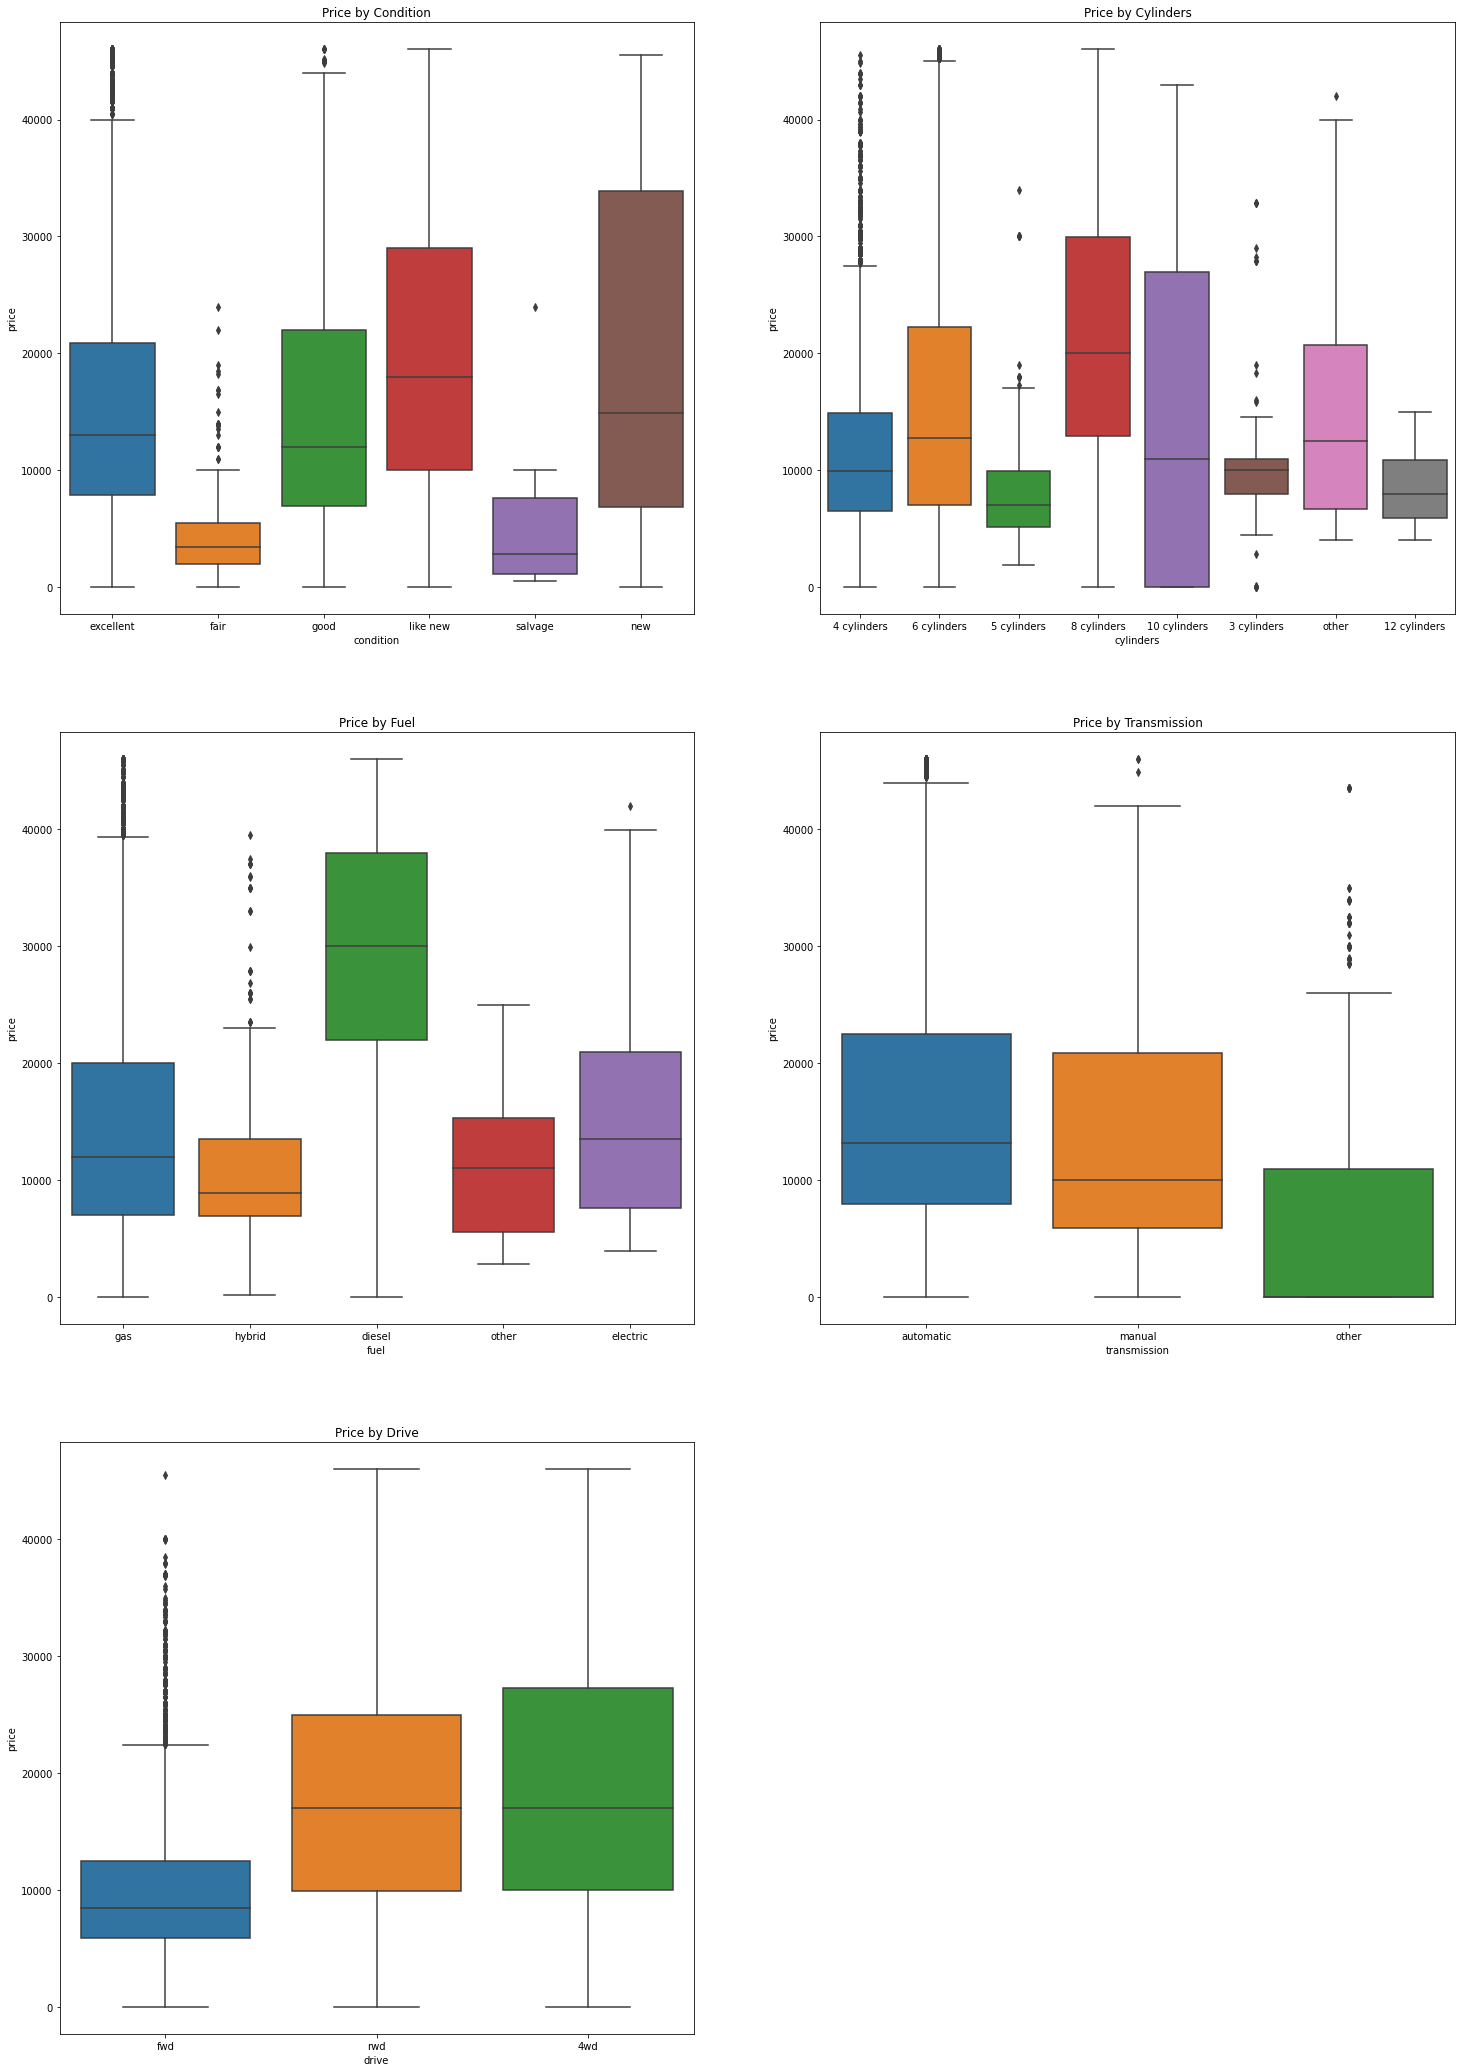

In [65]:
print('Condition:\n',df_odometer_normalized['condition'].value_counts())
print('\nCylinders:\n',df_odometer_normalized['cylinders'].value_counts())
print('\nFuel:\n',df_odometer_normalized['fuel'].value_counts())
print('\nTransmission:\n',df_odometer_normalized['transmission'].value_counts())
print('\nDrive:\n',df_odometer_normalized['drive'].value_counts())

fig=plt.figure(figsize=(25,37))
fig.add_subplot(3, 2, 1)
 
sns.boxplot(x='condition', y='price', data = df).set_title('Price by Condition')
fig.add_subplot(3, 2, 2)
sns.boxplot(x='cylinders', y='price', data = df).set_title('Price by Cylinders')
fig.add_subplot(3, 2, 3)
sns.boxplot(x='fuel', y='price', data = df).set_title('Price by Fuel')
fig.add_subplot(3, 2, 4)
sns.boxplot(x='transmission', y='price', data = df).set_title('Price by Transmission')
fig.add_subplot(3, 2, 5)
sns.boxplot(x='drive', y='price', data = df).set_title('Price by Drive')



1.   Consumers value year and odometer of the car the most in a used car. Therefore, it is suggested to raise new and less travelled cars inventory more.
2.   Cars with auto transmission tend to be more expensive than the others. Therefore, it is suggested to raise auto transmission cars inventory more.
3.   New and like-new cars tend to be more expensive, while cars with fair and salvage conditions tend to be cheaper. Therefore, it is suggested to raise new or fair-new cars inventory more.
4.   Cars with 8 or 10 cylinders tend to be more expensive, while 5 and 12-cylinder cars are cheaper. Therefore, it is suggested to raise 8 or 10 cylinders cars inventory more.
5.   Diesel cars are more expensive than other cars. Therefore, it is suggested to raise diesel cars inventory more.
6.   Cars equipped with 4-wheel and rare wheel drive tend to be more expensive than those with front-wheel drive. Therefore, it is suggested to raise 4-wheel and rare wheel drive cars inventory more.



